<a href="https://colab.research.google.com/github/movmarkio/AiDataQualityAnalyst/blob/main/SensorQualityAi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn pandas numpy matplotlib plotly


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving IOT-temp.csv to IOT-temp.csv


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import plotly.express as px

# Load the dataset
url = "IOT-temp.csv"  # Replace with the actual file path
df = pd.read_csv(url)

# Display the first few rows of the dataset
df.head()


,id,room_id/id,noted_date,temp,out/in
0,__export__.temp_log_196134_bd201015,Room Admin,08-12-2018 09:30,29,In
1,__export__.temp_log_196131_7bca51bc,Room Admin,08-12-2018 09:30,29,In
2,__export__.temp_log_196127_522915e3,Room Admin,08-12-2018 09:29,41,Out
3,__export__.temp_log_196128_be0919cf,Room Admin,08-12-2018 09:29,41,Out
4,__export__.temp_log_196126_d30b72fb,Room Admin,08-12-2018 09:29,31,In


In [ ]:
# Convert 'noted_date' to datetime format
df['noted_date'] = pd.to_datetime(df['noted_date'], format='%d-%m-%Y %H:%M')

# Check if the date was converted successfully
print(df['noted_date'].head())


0   2018-12-08 09:30:00
1   2018-12-08 09:30:00
2   2018-12-08 09:29:00
3   2018-12-08 09:29:00
4   2018-12-08 09:29:00
Name: noted_date, dtype: datetime64[ns]


In [ ]:
# Handle missing values for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Handle missing values for categorical columns (e.g., 'room_id/id' and 'out/in')
categorical_cols = df.select_dtypes(include=[object]).columns
# Example for filling missing values in each column with mode (most frequent value)
for col in df.columns:
    if df[col].isnull().sum() > 0:  # Check if there are any missing values in the column
        mode_value = df[col].mode()[0]  # Get the mode of the column
        df[col] = df[col].fillna(mode_value)  # Fill missing values with mode


# Check for any remaining missing values
print(df.isnull().sum())


id            0
room_id/id    0
noted_date    0
temp          0
out/in        0
dtype: int64


In [ ]:
# Encode the 'out/in' column: "In" = 1, "Out" = 0
df['out/in'] = df['out/in'].map({'In': 1, 'Out': 0})

# Check the transformed 'out/in' column
print(df['out/in'].head())


0    1
1    1
2    0
3    0
4    1
Name: out/in, dtype: int64


In [ ]:
# Convert the 'temp' column to numeric
df['temp'] = pd.to_numeric(df['temp'], errors='coerce')

# Fill missing values in 'temp' with the mean value of the column
df['temp'] = df['temp'].fillna(df['temp'].mean())


# Check the 'temp' column
print(df['temp'].head())


0    29
1    29
2    41
3    41
4    31
Name: temp, dtype: int64


In [ ]:
# Display cleaned dataset
print(df.head())

# Check for any remaining missing values
print(df.isnull().sum())


                                    id  room_id/id          noted_date  temp  \
0  __export__.temp_log_196134_bd201015  Room Admin 2018-12-08 09:30:00    29   
1  __export__.temp_log_196131_7bca51bc  Room Admin 2018-12-08 09:30:00    29   
2  __export__.temp_log_196127_522915e3  Room Admin 2018-12-08 09:29:00    41   
3  __export__.temp_log_196128_be0919cf  Room Admin 2018-12-08 09:29:00    41   
4  __export__.temp_log_196126_d30b72fb  Room Admin 2018-12-08 09:29:00    31   

   out/in  
0       1  
1       1  
2       0  
3       0  
4       1  
id            0
room_id/id    0
noted_date    0
temp          0
out/in        0
dtype: int64


In [ ]:
# Extract time-based features from 'noted_date'
df['hour'] = df['noted_date'].dt.hour
df['day_of_week'] = df['noted_date'].dt.dayofweek  # Monday=0, Sunday=6
df['is_weekend'] = df['day_of_week'] >= 5  # True if it's Saturday or Sunday

# Create rolling statistics over a window of 5 observations (can be adjusted)
df['rolling_mean'] = df['temp'].rolling(window=5).mean()
df['rolling_variance'] = df['temp'].rolling(window=5).var()

# Drop rows with NaN values due to rolling calculations
df.dropna(inplace=True)
print(df.isnull().sum())


# Preview the data
print(df.head())


id                  0
room_id/id          0
noted_date          0
temp                0
out/in              0
hour                0
day_of_week         0
is_weekend          0
rolling_mean        0
rolling_variance    0
dtype: int64
                                    id  room_id/id          noted_date  temp  \
4  __export__.temp_log_196126_d30b72fb  Room Admin 2018-12-08 09:29:00    31   
5  __export__.temp_log_196125_b0fa0b41  Room Admin 2018-12-08 09:29:00    31   
6  __export__.temp_log_196121_01544d45  Room Admin 2018-12-08 09:28:00    29   
7  __export__.temp_log_196122_f8b80a9f  Room Admin 2018-12-08 09:28:00    29   
8  __export__.temp_log_196111_6b7a0848  Room Admin 2018-12-08 09:26:00    29   

   out/in  hour  day_of_week  is_weekend  rolling_mean  rolling_variance  
4       1     9            5        True          34.2              39.2  
5       1     9            5        True          34.6              34.8  
6       1     9            5        True          34.6       

In [ ]:
# Simulate a failure column (e.g., temperature > 35 indicates failure)
df['failure'] = (df['temp'] > 35).astype(int)

# Separate features (X) and target (y)
X = df[['temp', 'rolling_mean', 'rolling_variance', 'hour', 'is_weekend']]
y = df['failure']

# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9776
           1       1.00      1.00      1.00      9745

    accuracy                           1.00     19521
   macro avg       1.00      1.00      1.00     19521
weighted avg       1.00      1.00      1.00     19521



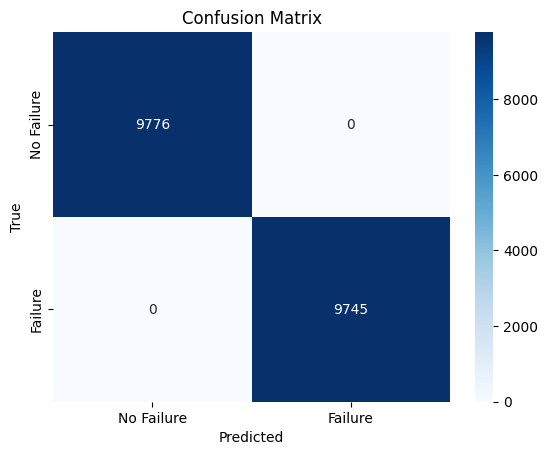

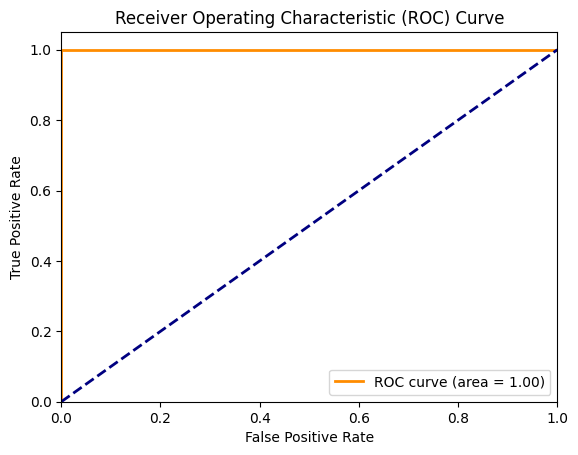

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Train a Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test_scaled)
y_prob = rf_model.predict_proba(X_test_scaled)[:, 1]  # Get probabilities for the positive class (Failure)

# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))

# Visualize confusion matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=["No Failure", "Failure"], yticklabels=["No Failure", "Failure"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning example (for Random Forest)
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
Best Score: 1.0
